# Practice Session 03: Find near-duplicates using shingling

Author: <font color="blue">Alan Le Roux Osorio</font>

E-mail: <font color="blue">alan.leroux01estudiant.upf.edu</font>

Date: <font color="blue">14/10/2025</font>

In [47]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import sys
from anyascii import anyascii




import datetime

In [ ]:
# KEEP AS-IS

# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []

# IMPORTANT:
# 1. Set this to 1000 during development
# 2. Set this to 10000 once you have completed the development
#    There is no need to re-run the time estimation
#    What is important is to answer part 5 with 10000
# 3. Set this back to 1000 for delivering your code
MAX_MESSAGES = 1000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                #author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


<font size="+1" color="red">Print two randomly chosen messages from the ones that were read, using random.sample()</font>

In [49]:
#We just sample two messages from the array defined previously
random.sample(messages, 2)



['RT @jordialapreso: Des d’ahir al vespre soc a infermeria seguint el protocol per aïllar qualsevol focus potencial de coronavirus. No tinc c…',
 'RT @VilaWeb: ÚLTIMA HORA: El president Torra anuncia el tancament de tota Catalunya https://t.co/AaRxRc0Wwp']

# 1. Auxiliary functions

In [143]:
#We define our function thaht will have as input two sets and will return the Jaccard similarity.
def jaccard_similarity(set1, set2):
    #The statement already tells us how to compute the jaccard similarity. THe length of the intersection
    set1 = set(set1)
    set2 = set(set2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if len(union) == 0:
        return 0
    return len(intersection) / len(union)

In [144]:
#Here we just create two sets from the messages array and we call the function defined above
set1 = set(messages[0].split())
set2 = set(messages[1].split())
jaccard_similarity(set1, set2)

0.07692307692307693

In [156]:

def clean_message(message):
    #We remove the "RT" prefixes
    message = re.sub(r'^RT\s+', '', message) 
    #We convert to lowercase
    message = message.lower()
    #Romanizing using anyascii
    #This line below was given by a classmate in the forum to remove emojis    
    message = re.sub(r'[\U00010000-\U0010ffff]', '', message) 
    message= anyascii(message) # Romanizing
    #We remove the urls
    message = re.sub(r'https?://\S+', '', message)
    #Remove spaces using the function strip
    message = message.strip()
    #remove anything that is not a letter or a digit
    message = re.sub(r'[^a-z0-9\s]', '', message)
    #Changing double spaces to single spaces
    message = re.sub(r'\s+', ' ', message)
    
    return message



In [157]:
#Testing the function with 5 diferent messages
tests = [
    # Check RT removal, lowercase, romanization (ñ to n)
    "RT Ñandú en el CAMPO!!!",  
    
    # Contains accents, non-Roman chars, and special letters
    "¡À bientôt, l·l català! ",  
    
    # Contains URLs
    "HTTPS://example.com PATH",  
    
    # Contains numbers and punctuation
    "released on 2025/10/15!",  
    
    #extra spaces, emoji, and random symbols
    "   Hello   world 😀 @#$%^&*()   "
]
for test in tests:
    print(f"Original: '{test}'")
    print(f"Cleaned:  '{clean_message(test)}'")
    print()

Original: 'RT Ñandú en el CAMPO!!!'
Cleaned:  'nandu en el campo'

Original: '¡À bientôt, l·l català! '
Cleaned:  'a bientot ll catala'

Original: 'HTTPS://example.com PATH'
Cleaned:  'path'

Original: 'released on 2025/10/15!'
Cleaned:  'released on 20251015'

Original: '   Hello   world 😀 @#$%^&*()   '
Cleaned:  'hello world '



# 2. Implement an n-gram extractor

In [158]:
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    #We first clean the message
    tokens = clean_message(text).split()
    #We remove tokens that are shorter than MIN_TOKEN_LENGTH
    tokens = [t for t in tokens if len(t) >= MIN_TOKEN_LENGTH]
    ngrams_list = []
    #We create the ngrams by iterating over the tokens
    for i in range(len(tokens) - size + 1):
        ngram = ' '.join(tokens[i:i+size])
        ngrams_list.append(ngram)
    return ngrams_list


In [160]:
print(messages[23])
print(ngrams(messages[23], 3))

RT @elnacionalcat: Àustria cancel·la els vols amb Espanya, França i Suïssa pel coronavirus https://t.co/zrLwT24otX
['elnacionalcat austria cancella', 'austria cancella els', 'cancella els vols', 'els vols amb', 'vols amb espanya', 'amb espanya franca', 'espanya franca suissa', 'franca suissa pel', 'suissa pel coronavirus']


# 3. Estimation of brute force all-pairs method

In [56]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean_message(messages[docid1])
        ngrams1 = set(ngrams(doc1, ngram_size))

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean_message(messages[docid2])
            ngrams2 = set(ngrams(doc2, ngram_size))

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

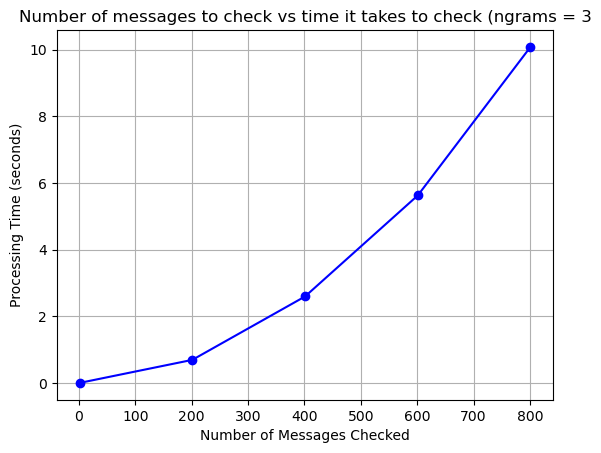

In [ ]:
number_messages = [] # we define an array that will represent the number of messages to check
time_required = [] # we define another array that will be the time it takes to check
#we iterate from 1 to 1000 with steps of 200 as stated in the assignment
for limit in range(1, 1001, 200):
    #We call the function defined previously to get the time it takes to check the similarities
    elapsed_time = time_brute_force_similarities(messages, limit, 3)
    number_messages.append(limit)
    time_required.append(elapsed_time)

#Now we plot the results using matplotlib
plt.plot(number_messages, time_required, marker='o',color = 'blue')
plt.title("Number of messages to check vs time it takes to check (ngrams = 3")
plt.xlabel("Number of Messages Checked")
plt.ylabel("Processing Time (seconds)")

plt.grid(True)
plt.show()

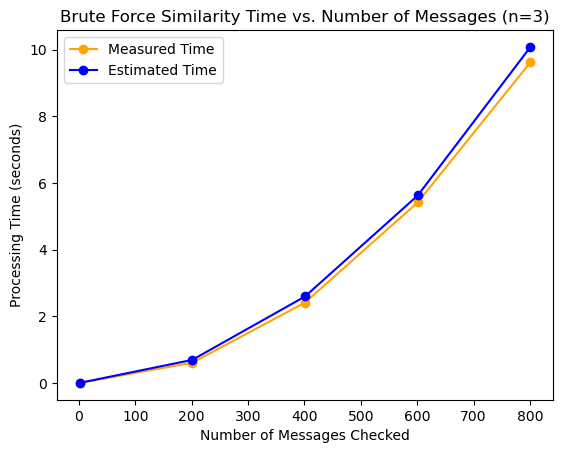

In [ ]:
#By brute force we know that the time complexity is O(n^2)
#So we will estimate the time required as a function of n^2
#We need to find the constant "a" such that time = a * n^2

#by brute force we find that a  = 0.000015 works well and fits correctly the measured times
a = 0.000015


time_estimated = [(a*(n**2.0)) for n in number_messages]
plt.plot(number_messages, time_estimated, marker='o',color = 'orange')
plt.plot(number_messages, time_required, marker='o',color = 'blue')
plt.title("Brute Force Similarity Time vs. Number of Messages (n=3)")
plt.xlabel("Number of Messages Checked")
plt.ylabel("Processing Time (seconds)")
plt.legend(["Measured Time", "Estimated Time"])
plt.grid(False)
plt.show()


In [ ]:
from datetime import timedelta
import humanize 
#We want to estimate the time for 35500 messages
#We use the constant found by trial and error
n = 35500
#the best value that fits the measured times is:
a = 0.000015

time_seconds = a*(n **2.0)

time_delta = timedelta(seconds=time_seconds)
human_read = humanize.precisedelta(time_delta)

print(f"Estimated time for {n} messages: {human_read}")

Estimated time for 35500 messages: 5 hours, 15 minutes and 3.75 seconds


By brute force we know that the time complexity is O(n^2).So we will estimate the time required as a function of n^2.We need to find the constant "a" such that time = a * n^2 .IN our case with n = 35500 a = 0.000015. This demonstrates that brute-force all-pairs comparison is computationally expensive and not practical for large datasets.

# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

In [186]:
NGRAM_SIZE = 3
ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        #we check if the ngram is already in the dictionary
        if ngram not in ngram_to_index:
            #If not we add it to both dictionaries
            ngram_to_index[ngram] = next_index
            index_to_ngram[next_index] = ngram
            next_index += 1

num_distinct_ngrams = next_index
print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))


There are 56253 distinct ngrams in the 10000 documents


In [187]:
test_ngrams = ['responsables amb que', 'les mesures contencio'] #This test was given by a teacher in the forum
#we test the two dictionaries with the ngrams above
for test_ngram in test_ngrams:
    if test_ngram in ngram_to_index:
        idx = ngram_to_index[test_ngram]
        print(f"ngram_to_index['{test_ngram}'] = {idx}")
        print(f"index_to_ngram[{idx}] = '{index_to_ngram[idx]}'\n")
    else:
        print(f"'{test_ngram}' not found in ngram_to_index\n")

ngram_to_index['responsables amb que'] = 710
index_to_ngram[710] = 'responsables amb que'

ngram_to_index['les mesures contencio'] = 1815
index_to_ngram[1815] = 'les mesures contencio'



## 2.2 Create table ngrams x documents

In [166]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 56253 rows (distinct shingles) x 10000 columns (distinct documents)


In [ ]:
#We first iterate through the documents

for docid in range(len(messages)):
    
    message = messages[docid]
    #we call the function defined previously to get the ngrams of the message
    all_ngrams = ngrams(message, 3)
    for ngram in all_ngrams:
        # We check if the ngram is in the dictionary
        if ngram in ngram_to_index:
            #If it is, we get its index and we set the corresponding cell in the matrix to True
            row = ngram_to_index[ngram]
            M_ngram_doc[row, docid] = True



In [170]:
#We compute the density of the matrix
#The density is the ratio of non-zero elements to the total number of elements
num_true = np.count_nonzero(M_ngram_doc)
# Count the total number of elements in the matrix
total_cells = M_ngram_doc.size
# Compute the density
density = (num_true / total_cells) * 100
print("Density of the matrix: %.4f%%" % density)

Density of the matrix: 0.0217%


In [171]:
# Print non-zero positions for docid 9602 and 941 (if within range)
for docid in [9602, 941]:
    if docid < len(messages):
        print(f"Positions of non-zeros in column of docid {docid} of M_ngram_doc\n")
        #We clean the message
        clean_msg = clean_message(messages[docid])
        print("Clean message:\n", clean_msg, "\n")
        # Find non-zero positions in the document's column
        nonzero_indices = np.where(M_ngram_doc[:, docid])[0]
        # Here we create a list of strings with the index and the corresponding ngram
        nonzeros = [f"{idx} ({index_to_ngram[idx]})" for idx in sorted(nonzero_indices)]
        print("Non-zeros in corresponding row:\n", nonzeros)
        
    else:
        print(f"docid {docid} is out of range (max docid is {len(messages)-1})\n")

Positions of non-zeros in column of docid 9602 of M_ngram_doc

Clean message:
 emergenciescat que puc fer i que no faqs del coronavirus a 14 de marc si us plau demanem difusio 

Non-zeros in corresponding row:
 ['949 (que puc fer)', '32561 (emergenciescat que puc)', '32562 (puc fer que)', '32563 (fer que faqs)', '32564 (que faqs del)', '32565 (faqs del coronavirus)', '32566 (del coronavirus marc)', '32567 (coronavirus marc plau)', '32568 (marc plau demanem)', '32569 (plau demanem difusio)']
Positions of non-zeros in column of docid 941 of M_ngram_doc

Clean message:
 hospiolot greyexclamationusem de forma responsable els recursos sanitaris 061arrowright urgencies per coronavirus i sanitaries 012arrowright consultes general 

Non-zeros in corresponding row:
 ['1157 (greyexclamationusem forma responsable)', '1158 (forma responsable els)', '1159 (responsable els recursos)', '1160 (els recursos sanitaris)', '1161 (recursos sanitaris 061arrowright)', '1162 (sanitaris 061arrowright urgencies

# 3. Implement a permutation generator

In [172]:

#we define the function random_permutation that returns a random permutation of integers from 0 to k-1
def random_permutation(k):
    perm = list(range(k))
    random.shuffle(perm)
    return perm

#we test the function with k=20
print(random_permutation(20))

[15, 10, 13, 2, 3, 18, 5, 9, 14, 7, 0, 6, 8, 11, 16, 4, 19, 17, 12, 1]


In [86]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['2 (test2)', '5 (test5)', '3 (test3)', '4 (test4)', '1 (test1)']
['2 (gamma)', '5 (epsilon)', '3 (beta)', '4 (delta)', '1 (alpha)']

Test another permutation
['5 (test5)', '2 (test2)', '3 (test3)', '4 (test4)', '1 (test1)']
['5 (epsilon)', '2 (gamma)', '3 (beta)', '4 (delta)', '1 (alpha)']


# 4. Compute the signature of each document

In [87]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 4 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, %d, ..." % (i,
                permutation[0], permutation[1], permutation[2], permutation[3] ))

Permutation 0: 50622, 51025, 383, 3686, ...
Permutation 1: 37442, 21602, 2246, 6104, ...
Permutation 2: 11357, 5418, 16163, 20745, ...
Permutation 3: 15773, 37702, 36854, 44273, ...
Permutation 4: 8549, 54684, 51047, 51040, ...


In [88]:
# LEAVE AS-IS

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

In [ ]:
# Create the signature matrix
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)
# We fill the signature matrix by iterating through permutations and documents
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    # And iterate through documents
    for docid in range(len(messages)):
        
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        
        # Then we find the signature value for this document and permutation
        signature_value = find_first_one(docid, permutation)
        # And store the signature value in the signature matrix
        M_signature_doc[permutation_num, docid] = signature_value
print("\nFinished creating the signature matrix.")

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [177]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean_message(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    #for ngram_index in extract_ngrams(i):
    #   print("     ", index_to_ngram[ngram_index])
    print("Signature     : %s" % extract_signature(i))

# Print two messages and their signatures

print_sig(messages, M_ngram_doc, M_signature_doc, 850 )
print()
print_sig(messages, M_ngram_doc, M_signature_doc, 400 )

Document #850
Message       : RT @btvnoticies: DIRECTE | Quim Torra anuncia el confinament de tot Catalunya

Pots seguir-ho en #directebetevé aquí ⤵

https://t.co/vW0uEY…
Clean message : btvnoticies directe quim torra anuncia el confinament de tot catalunya pots seguirho en directebeteve aqui arrowheadingdown
Ngrams        : [3921, 3922, 7621, 7622, 7623, 7624, 7625, 7626, 7627, 7628, 7629]
Signature     : [7626.0, 7624.0, 7629.0, 7629.0, 7626.0]

Document #400
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : gencat el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge es clau
Ngrams        : [3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927]
Signature     : [3924.0, 3926.0, 3923.0, 3921.0, 3919.0]


# 5. Compare all pairs of signatures

In [ ]:

#we first define ou r threshold as 0.5% of the number of messages (given in the assignment)
threshold = int(0.005 * len(messages))
if threshold < 1:
    threshold = 1
print(f"Using a match threshold of {threshold} (0.5% of {len(messages)} documents).")
print("Scanning for near-duplicates...")

is_possible_duplicate = {}
for docid1 in range(len(messages)):
    if docid1 not in is_possible_duplicate:
        count_sig_full_matches = 0
        count_sig_partial_matches = 0
        # Here I created a list to store the document ids of the partial matches
        matching_docs_partial = []
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))
        for docid2 in range(docid1 + 1, len(messages)):
            if docid2 not in is_possible_duplicate:
                # We extract the signature of the second document
                signature2 = extract_signature(docid2)
                # Then we compute the Jaccard similarity between the two signatures
                similarity = jaccard_similarity(signature1, signature2)
                #And we check the value of the similarity, depending on it will be a full or partial match
                if similarity == 1.0:
                    count_sig_full_matches += 1
                    is_possible_duplicate[docid2] = docid1 
                elif 0.2 < similarity < 1.0:
                    count_sig_partial_matches += 1
                    # Here I append the document id to the list of partial matches
                    matching_docs_partial.append(docid2)
                    is_possible_duplicate[docid2] = docid1
        #We compute the total matches and compare it to the threshold
        total_matches = count_sig_full_matches + count_sig_partial_matches
        if total_matches >= threshold:
            print(f"Document #{docid1} has {count_sig_full_matches} full matches "
                  f"and {count_sig_partial_matches} partial matches")
            print("Original tweet:", messages[docid1])

            # Print one example near-duplicate if any partial matches exist
            if matching_docs_partial:
                near_dup_id = matching_docs_partial[0]
                print("Example near-duplicate:", messages[near_dup_id])


Using a match threshold of 50 (0.5% of 10000 documents).
Scanning for near-duplicates...
0/10000 documents scanned
Document #16 has 71 full matches and 0 partial matches
Original tweet: RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
Document #19 has 11 full matches and 67 partial matches
Original tweet: RT @emergenciescat: El comitè tècnic del Pla #PROCICAT  per evitar la propagació del #coronavirus ha proposat al Govern que ordeni el cessa…
Example near-duplicate: RT @salutcat: Quines mesures de prevenció cal seguir per evitar la propagació del 🦠 #coronavirus SARS-CoV-2 👇

🔗 https://t.co/NS41dWDi9O ht…
Document #42 has 21 full matches and 31 partial matches
Original tweet: RT @VilaWeb: Els @mossos diuen que és més senzill confinar el Principat que diverses ciutats a la vegada https://t.co/piyLz82e9d
Example near-duplicate: RT @vpartal: Els Mossos diuen que és més senzill confinar el Principat

Original tweet: RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma...
This tweet has 71 full matches and 0 partial matches, which means it was retweeted or copied almost exactly, without modifications. The tweet likely comes from an official source (@emergenciescat) giving an urgent public safety message. Because of its importance and clarity, users may tend to share it , preserving the exact wordis

Original tweet: RT @emergenciescat: El comitè tècnic del Pla #PROCICAT  per evitar la propagació del #coronavirus ha proposat al Govern que ordeni el cessa…
Example near-duplicate: RT @salutcat: Quines mesures de prevenció cal seguir per evitar la propagació del 🦠 #coronavirus SARS-CoV-2 👇


This tweet shows 11 full matches and 67 partial matches, suggesting that it circulated  with slight variations. The changes might indicate that users  paraphrased the same message from different sources rather than retweeting the identical post.In this case is a news message , so the users just share the information between their followers but don't use the xact same words.

<font size="+2" color="#003300">I hereby declare that I completed this practice myself, that my answers were not written by an AI-enabled code assistant, and that except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>